# Setup

In [4]:
import pandas as pd
import requests

In [124]:
import warnings
warnings.filterwarnings('ignore')
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


In [6]:
try:
  import pygeos
except ModuleNotFoundError as e:
  !pip install pygeos==0.13
  import pygeos

In [7]:
try:
  import mapclassify
except ModuleNotFoundError as e:
  !pip install mapclassify
  import mapclassify

if mapclassify.__version__ != "2.4.3":
  !pip install -U mapclassify==2.4.3

In [8]:
try:
  import geopandas as gpd
except ModuleNotFoundError as e:
  !pip install geopandas==0.12.1
  import geopandas as gpd

if gpd.__version__ != "0.12.1":
  !pip install -U geopandas==0.12.1
  import geopandas as gpd

In [9]:
try:
  import pyrosm
except ModuleNotFoundError as e:
  !pip install pyrosm==0.6.1
  import pyrosm


In [10]:
try:
  import osmnx  as ox
except ModuleNotFoundError as e:
  !pip install osmnx==1.2.2
  import osmnx  as ox
if ox.__version__ != "1.2.2":
  !pip install -U osmnx==1.2.2
  import osmnx  as ox

In [11]:
import pandas as pd
from matplotlib import pyplot as plt

# Exercise

- identify the shortest path by walking to reach the Castle of Trento from the main train station of Trento
- identify the streets network orientation of the cities: Trento-Italy, Verona-Italy,  Munich-Germany, Athens-Greece 
- locate the student residences of Trento in OpenStreetMap and identify services in an area of 15 minutes based on the concept of [Carlos Moreno](https://twitter.com/CarlosMorenoFr) of [the 15 minute city](https://www.ted.com/talks/carlos_moreno_the_15_minute_city)<br/>
<i>"...a way to ensure that urban residents can fulfill six essential functions within a 15-minute walk [or bike] from their dwellings: living, working, commerce, healthcare, education and entertainment..."</i>

You are free to use OSMnx, Pyrosm with networkx or pandas or igraph

# identify the shortest path by walk to reach the Castle of Trento from the main train station
- where is the castle in Trento
- where is the main train station

## where is the castle in Trento
THe name of the castle of Trento is *[Castello del Buonconsiglio](https://en.wikipedia.org/wiki/Buonconsiglio_Castle)*




In [12]:
from geopy.geocoders import Nominatim

In [13]:
geolocator = Nominatim(user_agent="geospatial course")
location = geolocator.geocode("Museo del Castello del Buonconsiglio")

In [14]:
point_castle =  (location.latitude, location.longitude)

## where is the main train station in Trento?

[https://en.wikipedia.org/wiki/Trento_railway_station](https://en.wikipedia.org/wiki/Trento_railway_station)

In [15]:
location = geolocator.geocode("Piazza Dante 9, Trento")

In [16]:
point_train_station =  (location.latitude, location.longitude)

## download the data for PyrOSM

In [17]:
url_download_trento_pbf = 'https://osmit-estratti.wmcloud.org/dati/poly/comuni/pbf/022205_Trento_poly.osm.pbf'
import urllib.request
urllib.request.urlretrieve(url_download_trento_pbf ,"trento_osm.pbf")    
osm = pyrosm.OSM("trento_osm.pbf")

## create the streets walking graph

In [18]:
nodes, edges = osm.get_network(network_type="walking", nodes=True)

### with networkx

In [19]:
network_onx = osm.to_graph(nodes, edges, graph_type="networkx")
%time

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.63 µs


In [20]:
point_nearest_train_station = ox.distance.nearest_nodes(network_onx,Y=point_train_station[0],X=point_train_station[1])
point_nearest_castle = ox.distance.nearest_nodes(network_onx,Y=point_castle[0],X=point_castle[1])

### calculate the shortest path


In [21]:
shortest_path = ox.shortest_path(network_onx, point_nearest_train_station, point_nearest_castle, weight="length")

### show it on the map 



In [22]:
from shapely.geometry import Point, LineString

# function to create the route from the ids of the nodes
def route_nodes_to_line_networkx(nodelist, network,solution=1):
  points = []
  for idnode in nodelist:
    lon = network.nodes[idnode]['x']
    lat = network.nodes[idnode]['y']
    point = Point(lon,lat)
    points.append(point)
  path = LineString(points)
  route = gpd.GeoDataFrame(
    {"src_node": [nodelist[0]], "tgt_node": [nodelist[-1]], "solution": [solution]},
      geometry=[path],
      crs="epsg:4326"
  )
  return route


In [23]:
route_with_onx = route_nodes_to_line_networkx(shortest_path, network_onx)

In [24]:
route_with_onx

src_node    tgt_node  solution  \
0  2591984564  6036162196         1   

                                            geometry  
0  LINESTRING (11.11953 46.07204, 11.11957 46.072...

In [25]:
route_with_onx.explore()

In [26]:
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [27]:
route_with_onx.to_file("path_trainstation2castle_trento.kml", driver="KML")

.. and now you can visualize it with Google Earth

In [28]:
paths = ox.k_shortest_paths(network_onx, point_nearest_train_station, point_nearest_castle, k=10, weight="distance")

In [29]:
i = 0
gdf_paths = gpd.GeoDataFrame()
for path in paths:
    new_route = route_nodes_to_line_networkx(path, network_onx,solution=str(i))
    if i == 0:
        gdf_paths = new_route
    else:
        gdf_paths = gdf_paths.append(new_route)
    i += 1

In [30]:
gdf_paths.explore(column='solution',cmap="tab10",tiles="Stamen Toner")

In [31]:
gdf_paths[gdf_paths.solution == "0"].explore()

In [32]:
gdf_paths[gdf_paths.solution == "1"].explore()

In [33]:
gdf_paths[gdf_paths.solution == "2"].explore()

## with igraph

In [34]:
nodes, edges = osm.get_network(nodes=True, network_type="walking")

In [35]:
network_igraph = osm.to_graph(nodes, edges,graph_type='igraph')

In [36]:
from shapely.ops import nearest_points

In [37]:
# look code solutions of lesson 2
def get_nearest_id(id, points):
    # Create a union of points (multipoint geometry
    multipoints = points[points.id != id]["geometry"].unary_union
    # identify the starting point
    point = points[points.id == id]
    # find the nearest points
    nearest_geoms = nearest_points(point['geometry'].values[0], multipoints)
    # get corresponding values of the nearest point
    # note: in the position 0 there is the starting point
    nearest_data = points[points["geometry"] == nearest_geoms[1]]
    # extract the id of the nearest point
    nearest_id = nearest_data['id'].values[0]
    return (nearest_id)


In [38]:
# create geodaframe
node_ids = []
ids = []
points = []
for v in network_igraph.vs:
    node_id = v['node_id']
    id = v['id']
    p = Point(v['lon'],v['lat'])
    ids.append(id)
    points.append(p)
    node_ids.append(node_id)
data = {}
data['id'] = ids
data['node_id'] = node_ids
data['geometry'] = points
gdf_vertex = gpd.GeoDataFrame(data,crs="epsg:4326")    

In [39]:
multipoints = gdf_vertex.unary_union

In [40]:
point_trainstation = Point(point_train_station[1],point_train_station[0])
point_castle = Point(point_castle[1],point_castle[0])

In [41]:
nearest_geoms_train = nearest_points(point_trainstation, multipoints)
nearest_geoms_castle = nearest_points(point_castle, multipoints)

In [42]:
pstation = gdf_vertex[gdf_vertex.geometry == nearest_geoms_train[1]]
pcastle = gdf_vertex[gdf_vertex.geometry == nearest_geoms_castle[1]]

In [43]:
pstation

id  node_id                   geometry
39180  2591984564    39180  POINT (11.11953 46.07204)

In [44]:
idnodes_path = network_igraph.get_shortest_paths(pstation.node_id.values[0],to=pcastle.node_id.values[0])[0]

In [45]:
gdf_nodes_path = gdf_vertex[gdf_vertex.node_id.isin(idnodes_path)]

In [46]:
gdf_nodes_path.explore(marker_kwds={"color": "green", "radius": "10"})

## identify the streets network orientation of this list of cities
### Trento-Italy, Verona-Italy,  Munich-Germany, Athens-Greece

The suggestion is to read the blog [Street Network Orientation](https://geoffboeing.com/2018/02/street-network-orientation/) post of [Geoff Boeing](https://geoffboeing.com/) (author of [OSMnx](https://geoffboeing.com/publications/osmnx-complex-street-networks/)) and adapt also che script present in the [examples section](https://github.com/gboeing/osmnx-examples) on the OSMnx github repository.

From the script you have simple to change the names of the cities ... and .. understand the code.

In [47]:
# define the study sites as label : query
places = {
    'Trento' : "Trento, Territorio Val d'Adige, Provincia di Trento, Trentino-Alto Adige/Südtirol, Italy",
    "Verona": "Verona, Veneto, Italy",
    "Munich": "Munich, Bavaria, Germany",
    "Athens": "Περιφερειακή Ενότητα Κεντρικού Τομέα Αθηνών"
}

In [48]:
# verify OSMnx geocodes each query to what you expect (i.e., a [multi]polygon geometry)
gdf = ox.geocode_to_gdf(list(places.values()))
gdf

geometry  bbox_north  bbox_south  \
0  POLYGON ((11.02247 46.05027, 11.02296 46.05019...   46.153011   45.977531   
1  POLYGON ((10.87685 45.46084, 10.87712 45.46017...   45.541837   45.349440   
2  MULTIPOLYGON (((11.36078 48.15807, 11.36085 48...   48.248116   48.061624   
3  POLYGON ((23.68700 37.97844, 23.68749 37.97825...   38.059134   37.915813   

   bbox_east  bbox_west   place_id  osm_type   osm_id        lat        lon  \
0  11.194823  11.022474  297532930  relation    46663  46.066423  11.125760   
1  11.123900  10.876851  297101238  relation    44830  45.438496  10.992412   
2  11.722910  11.360777  297759456  relation    62428  48.137108  11.575382   
3  23.823200  23.687005  298197509  relation  2604796  37.987486  23.740311   

                                        display_name     class  \
0  Trento, Territorio Val d'Adige, Provincia di T...  boundary   
1                              Verona, Veneto, Italy  boundary   
2                           Munich, Bavaria, Germany  boundary   
3    Regional Unit of Central Athens, Attica, Greece  boundary   

             type  importance  
0  administrative    1.932529  
1  administrative    0.976157  
2  administrative    1.076211  
3  administrative    0.419111

In [49]:
gdf.explore()

https://www.oraask.com/wiki/draw-a-polar-histogram-in-matplotlib

In [50]:
# import numpy as np
# n = len(places)
# ncols = int(np.ceil(np.sqrt(n)))
# nrows = int(np.ceil(n / ncols))
# figsize = (ncols * 5, nrows * 5)
# fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={"projection": "polar"})
# # plot each city's polar histogram

# for ax, place in zip(axes.flat, sorted(places.keys())):
#     print(ox.utils.ts(), place)

#     # get undirected graphs with edge bearing attributes
#     G = ox.graph_from_place(place, network_type="drive")
#     Gu = ox.add_edge_bearings(ox.get_undirected(G))
#     fig, ax = ox.bearing.plot_orientation(Gu, ax=ax, title=place, area=True)

# # add figure title and save image
# suptitle_font = {
#     "family": "Arial",
#     "fontsize": 60,
#     "fontweight": "normal",
#     "y": 1,
# }
# fig.suptitle("City Street Network Orientation") #, **suptitle_font)
# fig.tight_layout()
# fig.subplots_adjust(hspace=0.35)
# fig.savefig("street-orientations.png", facecolor="w", dpi=100, bbox_inches="tight")
# plt.close()


Here the result

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/street-orientations.png)



.. and here the result for all the main cities of Italy

![](https://raw.githubusercontent.com/napo/geospatial_course_unitn/master/images/italian_city_strees_orientation.jpg)

Vladimir Agafonkin created the web verson
 
![](https://github.com/napo/geospatial_course_unitn/blob/master/images/web_street_orientation.jpg?raw=true)

[https://mourner.github.io/road-orientation-map/#13.49/45.43646/12.33136](https://mourner.github.io/road-orientation-map/#13.49/45.43646/12.33136)

Here a simple map with the information of some cities in Trentino long the river Adige.

![](https://github.com/napo/geospatial_course_unitn/blob/master/images/trentino_orientamento_strade..jpg?raw=true)

[http://umap.openstreetmap.fr/en/map/orientamento-comuni-valle-delladige_234308#11/45.9588/11.1295](http://umap.openstreetmap.fr/en/map/orientamento-comuni-valle-delladige_234308#11/45.9588/11.1295)

## locate the student residences of Trento in OpenStreetMap and identify services in an area of 15 minutes based on the concept of [Carlos Moreno](https://twitter.com/CarlosMorenoFr) of [the 15 minute city](https://www.ted.com/talks/carlos_moreno_the_15_minute_city)<br/>
<i>"...a way to ensure that urban residents can fulfill six essential functions within a 15-minute walk [or bike] from their dwellings: living, working, commerce, healthcare, education and entertainment..."</i>

### Data from OpenStreetMap
[identify the tags](https://wiki.openstreetmap.org/wiki/Map_features) for:
* [commerce](https://wiki.openstreetmap.org/wiki/Map_features#Commercial):
    * building = commercial, industrial, kiosk, retail, supermarket, warehouse
    * shop = *
    * amenity = bar, pub, cafe, restaurant, fast_food, food_court, ice_cream
* [healthcare](https://wiki.openstreetmap.org/wiki/Map_features#Healthcare)
    * amenity = baby_hatch,clinic,dentist, doctors, hospital, nursing_home, pharmacy, social_facility, veterinary 
* [education](https://wiki.openstreetmap.org/wiki/Map_features#Education)
    * amenity = college, driving_school, kindergarten, language_school, library, toy_library, training, music_school, university
* [entertainment](https://wiki.openstreetmap.org/wiki/Map_features#Entertainment,%20Arts%20&%20Culture)
    * amenity =  arts_centre, cinema, community_centre, events_venue, fountain, social_facility, gambling, planetarium, public_bookcase, social_centre, studio, theatre
* [living](https://wiki.openstreetmap.org/wiki/Map_features#Public%20Service)
    * amenity = courthouse, fire_station, police, post_box, post_office, ranger_station, townhall
     


In [109]:
buildings = ox.geometries.geometries_from_place("Trento, Territorio Val d'Adige, Provincia di Trento, Trentino-Alto Adige/Südtirol, Italy", tags = {'building': True})
amenities = ox.geometries.geometries_from_place("Trento, Territorio Val d'Adige, Provincia di Trento, Trentino-Alto Adige/Südtirol, Italy", tags = {'amenity': True})
shops = ox.geometries.geometries_from_place("Trento, Territorio Val d'Adige, Provincia di Trento, Trentino-Alto Adige/Südtirol, Italy", tags = {'shop': True})

amenity = student_accommodation

In [125]:
student_accomodations = amenities[amenities.amenity.isin(["student_accommodation"])]

transform in POI (with some bias)

In [126]:
student_accomodations['geometry'] = student_accomodations.geometry.representative_point()

create isocrhones for each student accomodations

In [141]:
import networkx as nx
G_proj = ox.project_graph(network_onx)
travel_speed = 4  # walking speed in km/hour


In [166]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for orig,dest, p, data in G_proj.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [169]:
crs_proj = ox.graph_to_gdfs(G_proj)[0].crs

In [157]:
# create the isochrone polygons
isochrone_polys = []
names = []
for i in range(len(student_accomodations.geometry)):
    center_node = ox.distance.nearest_nodes(network_onx,Y=student_accomodations.geometry[i].y,X=student_accomodations.geometry[i].x)
    name = student_accomodations[student_accomodations.geometry==student_accomodations.geometry[i]].name.values[0]
    subgraph = nx.ego_graph(G_proj, center_node, radius=15, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
    names.append(name)


In [170]:
data = {}
data['name'] = names
data['geometry'] = isochrone_polys
isochrones_student_accomodations = gpd.GeoDataFrame(data,crs=crs_proj)    

commerce

In [384]:
commerce = ["commercial","industrial", "kiosk", "retail", "supermarket", "warehouse"]
commerce_amenity = ["bar","pub","cafe","restaurant","fast_food","food_court","ice_cream"]

In [385]:
pois_commerce = buildings[buildings.building.isin(commerce)]
pois_shops = shops 
pois_commerce_amenities = amenities[amenities.amenity.isin(commerce_amenity)]

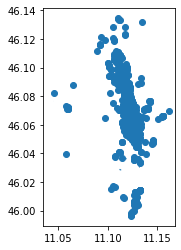

In [386]:
pois_shops.plot()
plt.show()

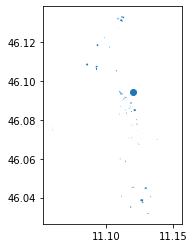

In [387]:
pois_commerce.plot()
plt.show()

In [388]:
pois_commerce.explore(tooltip=['building'])

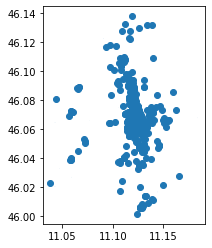

In [389]:
pois_commerce_amenities.plot()
plt.show()

In [391]:
pois_commerce_amenities.explore(tooltip=['amenity'])

healthcare

In [302]:
healthcare_amenity_values = ["baby_hatch","clinic,dentist","doctors","hospital","nursing_home","pharmacy","social_facility","veterinary"]
pois_healthcare = amenities[amenities.amenity.isin(healthcare_amenity_values)]


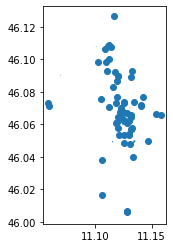

In [303]:
pois_healthcare.plot()
plt.show()

education

In [304]:
education_amenity_values = ["college","driving_school","kindergarten","language_school","library","toy_library","training","music_school","university"]
pois_education = amenities[amenities.amenity.isin(education_amenity_values)]


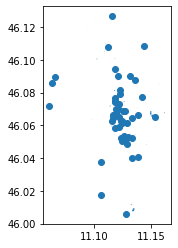

In [305]:
pois_education.plot()
plt.show()

entertainment

In [306]:
entertainment_amenity_values = ["arts_centre","cinema","community_centre","events_venue","fountain","social_facility","gambling","planetarium","public_bookcase","social_centre","studio","theatre"]
pois_entertainment = amenities[amenities.amenity.isin(entertainment_amenity_values)]


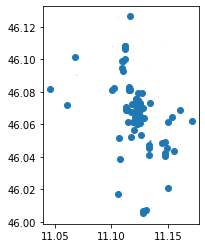

In [307]:
pois_entertainment.plot()
plt.show()

living

In [308]:
living_amenity_values = ["courthouse","fire_station","police","post_box","post_office","ranger_station","townhall"]
pois_living = amenities[amenities.amenity.isin(living_amenity_values)]


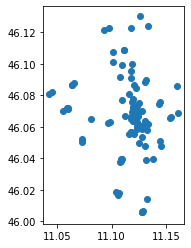

In [309]:
pois_living.plot()
plt.show()

cross the area

In [310]:
isochrones_student_accomodations = isochrones_student_accomodations.to_crs(epsg=4326)

... you can use different approach<br/>
this is made only to repeat some concepts presented in the previous lessons

In [375]:
def checkInsideArea(p,i):
    touch = False
    try:
        touch = p.within(i)
    except Exception as e:
        print(e)
        pass
    if touch == False:
        return False
    else:
        return True

In [376]:
names = {}
for idx, row in isochrones_student_accomodations.iterrows():
    name = row['name']
    label = "student_accomodation_" + str(idx)
    names[label] = name
    polygon = row.geometry
    pois_living[label] = pois_living.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_entertainment[label] = pois_entertainment.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_education[label] = pois_education.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_healthcare[label] = pois_healthcare.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_commerce[label] = pois_commerce.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_shops[label] = pois_healthcare.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_commerce[label] = pois_commerce.geometry.apply(lambda g: checkInsideArea(g,row.geometry))
    pois_commerce_amenities[label] = pois_commerce_amenities.geometry.apply(lambda g: checkInsideArea(g,row.geometry))

In [377]:
for name in names:
    living_places = pois_living[pois_living[name] == True].shape[0]
    entertainment_places = pois_entertainment[pois_entertainment[name] == True].shape[0]
    education_places = pois_education[pois_education[name] == True].shape[0]
    healthcare_places = pois_healthcare[pois_healthcare[name] == True].shape[0]
    commerce_places = pois_commerce[pois_commerce[name] == True].shape[0]
    commerce_places += pois_shops[pois_shops[name] == True].shape[0]
    commerce_places += pois_commerce_amenities[pois_commerce_amenities[name] == True].shape[0]
    total = commerce_places + living_places + education_places + healthcare_places + entertainment_places
    print(names[name])
    print("living places %s" % living_places)
    print("entertainment places %s" % entertainment_places)
    print("education places %s" % education_places)
    print("healthcare places %s" % healthcare_places)
    print("commerce places %s" % commerce_places)
    print("TOTAL %s" % total)
    print(" ")

Studentato San Bartolameo
living places 0
entertainment places 2
education places 0
healthcare places 0
commerce places 1
TOTAL 3
 
Collegio Bernardo Clesio
living places 2
entertainment places 1
education places 5
healthcare places 0
commerce places 58
TOTAL 66
 
Studentato Mayer
living places 3
entertainment places 1
education places 3
healthcare places 1
commerce places 13
TOTAL 21
 
NEST
living places 1
entertainment places 1
education places 1
healthcare places 0
commerce places 5
TOTAL 8
 
